# Copyright

<PRE>
This notebook was created as part of the "Deep learning / VITMMA19" class at
Budapest University of Technology and Economics, Hungary,
https://portal.vik.bme.hu/kepzes/targyak/VITMMA19.

Any re-use or publication of any part of the notebook is only allowed with the
written consent of the authors.

2024 (c) Mohammed Salah Al-Radhi (malradhi@tmit.bme.hu)
</PRE>

# Regression example
This Jupyter Notebook contains a basic example of regression with linear regression, random forest and a deep neural network. The dataset we will use is the insurance dataset, which contains information about individuals and their medical insurance costs. We will preprocess the data, visualize it, and train different models on it. Finally, we will evaluate the models and compare their performance.
First, we install [Pytorch Lightning](https://lightning.ai/), which will be used as an easy-to-use interface to PyTorch.


In [94]:
#pip install matplotlib seaborn --quiet

In [95]:
!pip install pytorch-lightning --quiet

## Data
Download the dataset:

In [96]:
!wget https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv

--2024-10-29 22:10:15--  https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54288 (53K) [text/plain]
Saving to: ‘insurance.csv.1’

insurance.csv.1     100%[===================>]  53.02K  --.-KB/s    in 0.004s  

2024-10-29 22:10:15 (13.1 MB/s) - ‘insurance.csv.1’ saved [54288/54288]



## Imports
Importing libraries for data preprocessing & visualization:

In [100]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

In [101]:
# Load and preprocess the data
data = pd.read_csv('insurance.csv')
X = data.drop(columns=['charges'])
y = data['charges']
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [103]:
data = pd.get_dummies(data, drop_first=True) # we have to talk about drop_first -> avoid the dummy variable trap
data

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,True,False,True,False,False
1334,18,31.920,0,2205.98080,False,False,False,False,False
1335,18,36.850,0,1629.83350,False,False,False,True,False
1336,21,25.800,0,2007.94500,False,False,False,False,True


In [104]:
data.dtypes

,0
age,int64
bmi,float64
children,int64
charges,float64
sex_male,bool
smoker_yes,bool
region_northwest,bool
region_southeast,bool
region_southwest,bool


In [105]:
data.iloc[:, :4] = data.iloc[:, :4].astype('float32')

<ipython-input-105-0cc81c5c5264>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       19.0
1       18.0
2       28.0
3       33.0
4       32.0
        ... 
1333    50.0
1334    18.0
1335    18.0
1336    21.0
1337    61.0
Name: age, Length: 1338, dtype: float32' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.iloc[:, :4] = data.iloc[:, :4].astype('float32')
<ipython-input-105-0cc81c5c5264>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       0.0
1       1.0
2       3.0
3       0.0
4       0.0
       ... 
1333    3.0
1334    0.0
1335    0.0
1336    0.0
1337    0.0
Name: children, Length: 1338, dtype: float32' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.iloc[:, :4] = data.iloc[:, :4].astype('float32')


In [106]:
data.dtypes

,0
age,float32
bmi,float64
children,float32
charges,float64
sex_male,bool
smoker_yes,bool
region_northwest,bool
region_southeast,bool
region_southwest,bool


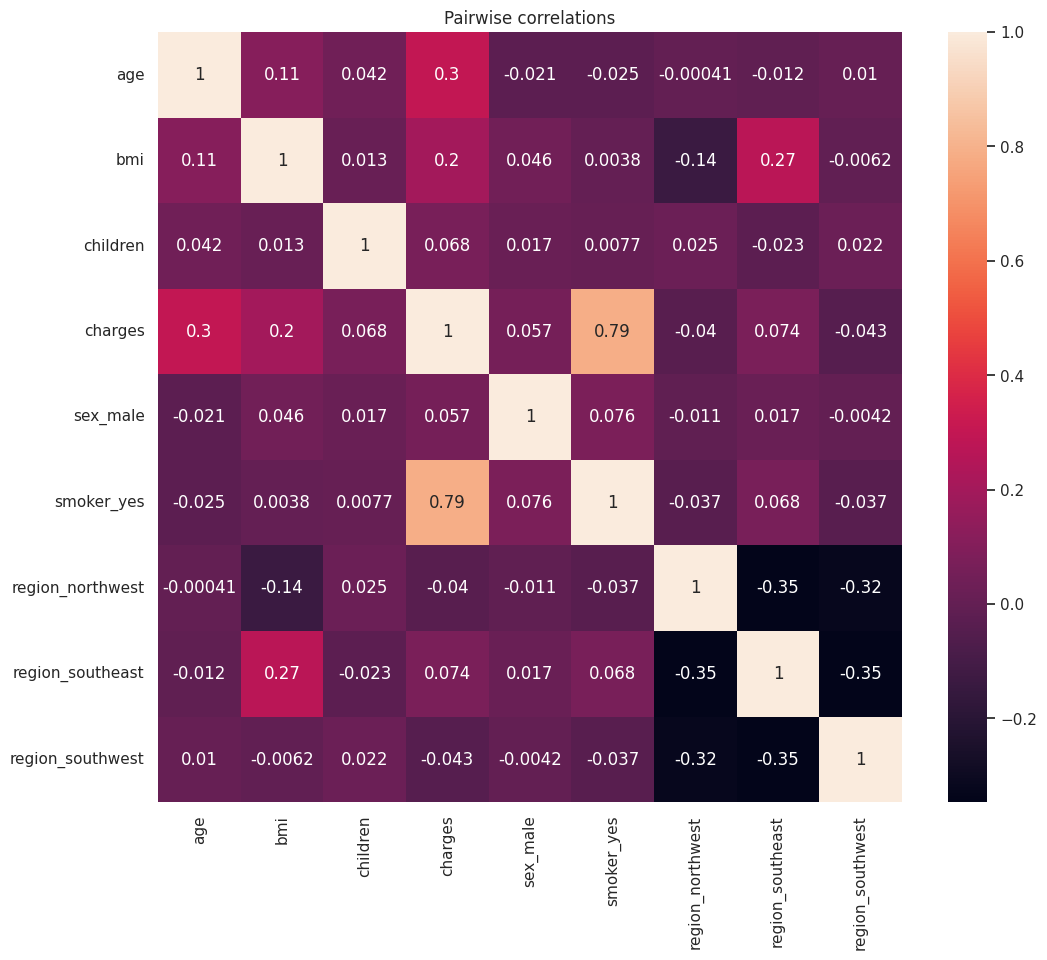

In [107]:
plt.figure(figsize=(12, 10))
plt.title('Pairwise correlations')
sns.heatmap(data=data.corr(), annot=True)
plt.show()

In [108]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [109]:
# Preprocessing pipeline
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [110]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.todense(), dtype=torch.float32) if hasattr(X_train, "todense") else torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.todense(), dtype=torch.float32) if hasattr(X_test, "todense") else torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [111]:
# Define the FeedForward Neural Network
class FeedForwardNet(pl.LightningModule):
    def __init__(self, input_dim):
        super(FeedForwardNet, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 128)
        self.layer_2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.3)  # Adding Dropout
        self.layer_3 = nn.Linear(64, 1)
        self.criterion = nn.L1Loss()  # MAE Loss

    def forward(self, x):
        x = torch.relu(self.layer_1(x))
        x = self.dropout(x)  # Apply dropout
        x = torch.relu(self.layer_2(x))
        return self.layer_3(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        val_loss = self.criterion(y_hat, y)
        self.log("val_loss", val_loss, prog_bar=True)
        return val_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-2)

In [112]:
# Model training with checkpointing
input_dim = X_train.shape[1]
model = FeedForwardNet(input_dim=input_dim)
#Here is the line of code for saving best performing model
#This below line of code specifies the name of the checkpoint file (it will automatically add .ckpt).
checkpoint_callback = ModelCheckpoint(monitor="val_loss", filename="best_model", mode="min")
trainer = pl.Trainer(max_epochs=100, callbacks=[checkpoint_callback], log_every_n_steps=10)
trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | layer_1   | Linear  | 1.5 K  | train
1 | layer_2   | Linear  | 8.3 K  | train
2 | dropout   | Dropout | 0      | train
3 | layer_3   | Linear  | 65     | train
4 | criterion | L1Loss  | 0      | train
----------------------------------------------
9.9 K     Trainable params
0         Non-trainable params
9.9 K     Total params
0.039     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [113]:
# Load the best model and evaluate
# Assuming CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and move it to the appropriate device
best_model = FeedForwardNet.load_from_checkpoint(checkpoint_callback.best_model_path, input_dim=input_dim)
best_model.to(device)  # Move model to GPU

# Move input tensors to the same device
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)

best_model.eval()
with torch.no_grad():
    y_pred_train = best_model(X_train_tensor).squeeze().cpu().numpy()  # Move to CPU before numpy
    y_pred_test = best_model(X_test_tensor).squeeze().cpu().numpy()    # Move to CPU before numpy


In [114]:
# Calculate metrics
mae_nn = mean_absolute_error(y_test, y_pred_test)
print(f"Mean Absolute Error: {mae_nn}")
r2_nn = r2_score(y_test, y_pred_test)
print(f"Coefficient of Determination: {r2_nn}")


Mean Absolute Error: 1764.735774958372
Coefficient of Determination: 0.864237704126433


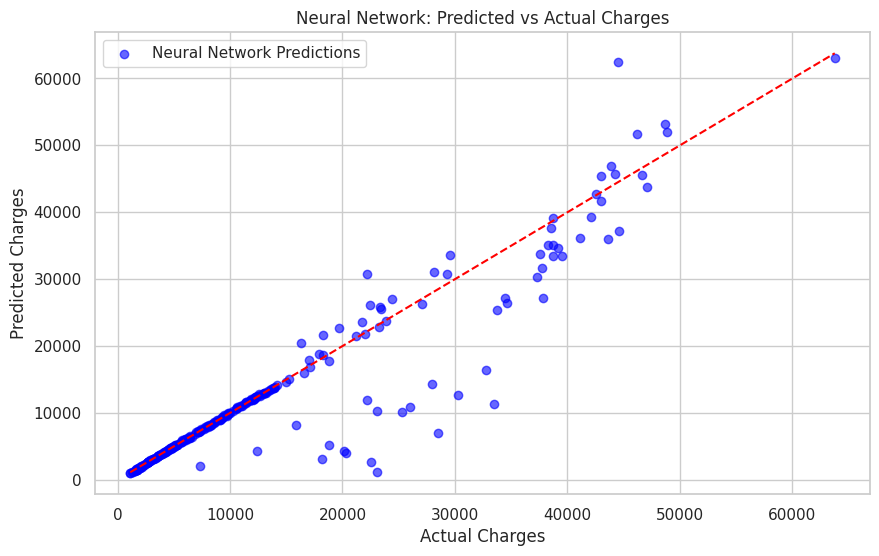

Mean Absolute Error: 1764.735774958372
Coefficient of Determination: 0.864237704126433


In [115]:
# Set seaborn style
sns.set(style="whitegrid")
# 1. Predicted vs Actual for Neural Network
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, color='blue', label='Neural Network Predictions', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Neural Network: Predicted vs Actual Charges')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.legend()
plt.show()

#Evaluation
# Calculate metrics
mae_nn = mean_absolute_error(y_test, y_pred_test)
print(f"Mean Absolute Error: {mae_nn}")
r2_nn = r2_score(y_test, y_pred_test)
print(f"Coefficient of Determination: {r2_nn}")

In [117]:
# Saving the MAE and the R2 score of my best performing model into a csv file called mlp_results.csv.
nn_results = pd.DataFrame({"MAE": [mae_nn], "R2": [r2_nn]})
nn_results.to_csv("mlp_results.csv", index=False)

In [118]:
# Train a RandomForest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [119]:
# Predictions for ensemble
y_pred_rf = rf_model.predict(X_test)
y_pred_ensemble = 0.5 * y_pred_test + 0.5 * y_pred_rf

In [121]:
# Ensemble metrics
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
print(f"Ensemble Mean Absolute Error: {mae_ensemble}")
r2_ensemble = r2_score(y_test, y_pred_ensemble)
print(f" Ensemble Coefficient of Determination: {r2_ensemble}")

Ensemble Mean Absolute Error: 1970.270586404802
 Ensemble Coefficient of Determination: 0.8849865996015188


In [122]:
# Save ensemble results
ensemble_results = pd.DataFrame({"MAE": [mae_ensemble], "R2": [r2_ensemble]})
ensemble_results.to_csv("ensemble_results.csv", index=False)

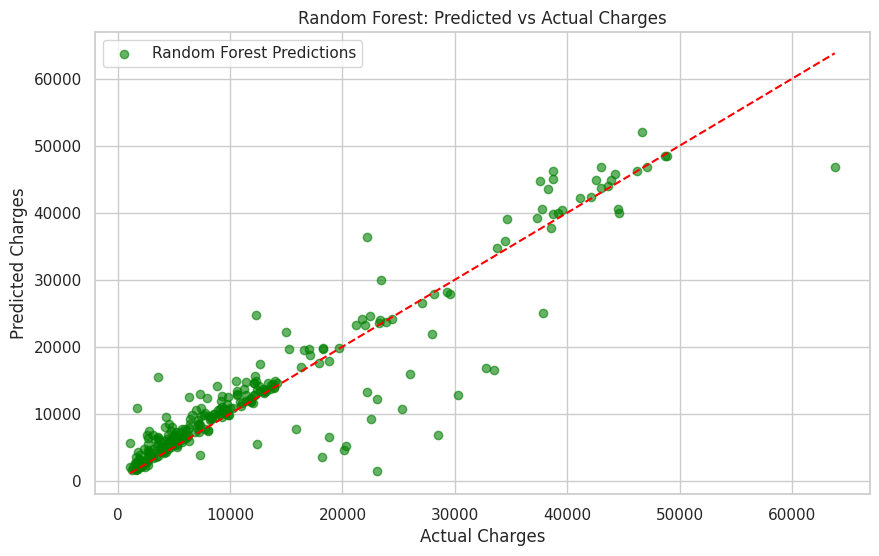

In [124]:
# Predicted vs Actual for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, color='green', label='Random Forest Predictions', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Random Forest: Predicted vs Actual Charges')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.legend()
plt.show()

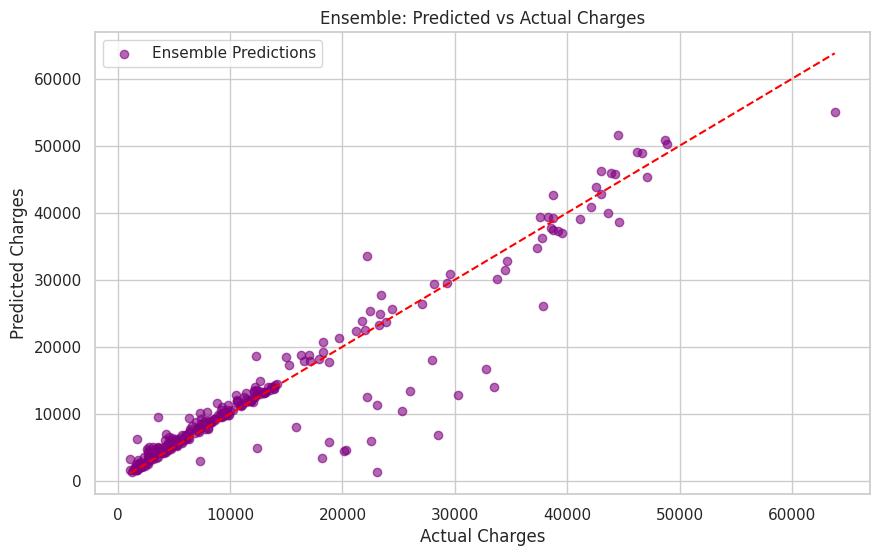

In [125]:
#Scatter Plot: Ensemble Predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ensemble, color='purple', label='Ensemble Predictions', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Ensemble: Predicted vs Actual Charges')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.legend()
plt.show()

In [129]:
#Finally, To download the saved results
from google.colab import files
# Download the saved CSV files
files.download("mlp_results.csv")
files.download("ensemble_results.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>







Thank You